# Polynomial Chaos Expansion with a simple SEIR model

## Introduction

In this notebook we will use Polynomial Chaos expansion on a simple SEIR model, which is given by

\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= - \beta IS \tag{Susceptible}\\
\frac{\mathrm{d}E}{\mathrm{d}t} &= \beta IS - \alpha E  \tag{Exposed}\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= -\gamma I + \alpha E \tag{Infectious}\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I \tag{Recovered}
\end{align*}

With the initial condition $(S(0), E(0), I(0), R(0)) = (1-\delta, \delta, 0, 0)$ for some small $\delta$.

### Parameters

We have three parameters in this model, $\alpha, \beta$ and $\gamma$. For those we assume for now that $\alpha \sim \mathcal{U}(0.15, 0.25)$, $\beta \sim \mathcal{U}(0.95, 1.05)$ and that $\gamma \sim \mathcal{U}(0.45, 0.55)$

# Chaospy

For this example we are going to use the ChaosPy library to solve this model

In [15]:
%matplotlib inline

In [16]:
import numpy as np
import chaospy
import matplotlib.pyplot as plt
from scipy.integrate import odeint

* First we're going to define a function which describes the SEIR ODE

In [17]:
def ode_SEIR(y, t, parameters):
    [S, E, I, R] = y
    [alpha, beta, gamma] = parameters
    
    dS = -beta * I * S
    dE = beta * I * S - alpha * E
    dI = -gamma * I + alpha * E
    dR = gamma * I
    
    return np.array([dS, dE, dI, dR])

* Then we're going to integrate this ODE on $[0, 200]$ using $1000$ steps

Text(0, 0.5, '% of population')

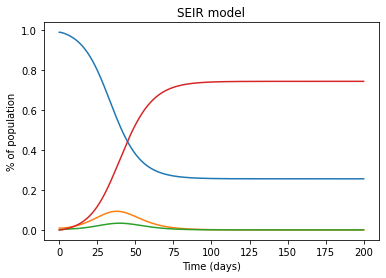

In [18]:
coordinates = np.linspace(0, 200, 1000)
initial_cond = [0.99, 0.01, 0, 0]
param = [0.2, 1.0, 0.55]

y = odeint(ode_SEIR, initial_cond, coordinates, args=(param,))

fig, ax = plt.subplots()
ax.plot(coordinates, y[:, 0])
ax.plot(coordinates, y[:, 1])
ax.plot(coordinates, y[:, 2])
ax.plot(coordinates, y[:, 3])

ax.set_title('SEIR model')
ax.set_xlabel('Time (days)')
ax.set_ylabel('% of population')

* We now have our base line model, and can see that it works. 
* Now it's time to make the parameters stochastic and apply a PCE

In [19]:
# Declare our random parameters
alpha = chaospy.Uniform(0.15, 0.25)
beta = chaospy.Uniform(0.70, 0.8)
gamma = chaospy.Uniform(0.45, 0.55)
distribution = chaospy.J(alpha, beta, gamma)

# Initial conditions from the Julia program
initial_cond = [1 - 1e-4, 1e-4, 0, 0]

# Generate our PCE basis
polynomial_order = 4
polynomial_expansion = chaospy.generate_expansion(
    polynomial_order, distribution)

# Generate our quadrature nodes and weights
quadrature_order = 8
abscissas, weights = chaospy.generate_quadrature(
    quadrature_order, distribution, rule="gaussian")

# lambda to wrap our ODE solver
model = lambda params: odeint(ode_SEIR, initial_cond, coordinates, args=(params,))

In [20]:
# Now we're going to build PCE
evaluations = [
    model(abscissa) for abscissa in abscissas.T
]
foo_approx = chaospy.fit_quadrature(
    polynomial_expansion, abscissas, weights, evaluations)

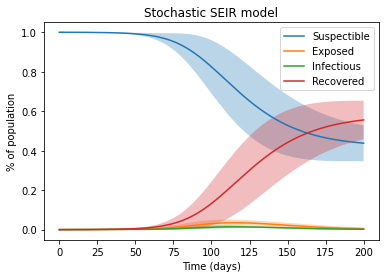

In [21]:
# Calculate the mean and the standard deviations
expected = chaospy.E(foo_approx, distribution)
std = chaospy.Std(foo_approx, distribution)

# Plot the data with uncertainty intervals
plt.xlabel("Time (days)")
plt.ylabel("% of population")
plt.title('Stochastic SEIR model')
labels = ['Suspectible', 'Exposed', 'Infectious', 'Recovered']
for idx in range(0, 4):
    plt.fill_between(
        coordinates, expected[:, idx] - std[:, idx], expected[:, idx] + std[:, idx], alpha = 0.3)
    plt.plot(coordinates, expected[:, idx], label = labels[idx])
plt.legend()